# 0. Load X and y

In [7]:
from backend.interface.main import main

main()


✅ X has been initialized with Shape (63, 10, 150, 150, 3)!
✅ y has been initialized with Shape (63, 6)!

✅ X_val has been initialized with Shape (19, 10, 150, 150, 3)!
✅ y_cat_val has been initialized with Shape (19, 6)!

✅ X_aug has been initialized with Shape (176, 10, 150, 150, 3)!
✅ y_aug has been initialized with Shape (176, 6)!


In [27]:
# %run data_preprocessing_Jaris.ipynb
# %run data_preprocessing_Jaris_test.ipynb
%run SignFlow_test.ipynb


✅ X has been initialized with Shape (63, 20, 256, 256, 3)!
✅ y has been initialized with Shape (63, 6)!
✅ X_aug has been initialized with Shape (484, 20, 256, 256, 3)!
✅ y_aug has been initialized with Shape (484, 6)!

✅ X_val has been initialized with Shape (19, 20, 256, 256, 3)!
✅ y_cat_val has been initialized with Shape (19, 6)!


In [28]:
# X = X_aug
print(X_aug.shape)
# y = y_cat
y = y_aug
print(y.shape)


(63, 20, 256, 256, 3)
(484, 6)


# 1. Import libraries

In [29]:
import os
import json
import numpy as np
import mediapipe as mp
# from mediapipe.solutions.drawing_utils import mp_drawing
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

mp_drawing = mp.solutions.drawing_utils


# 2. Get coordinates of X

### 2.1 Define functions to get coordinates for one frame
https://developers.google.com/mediapipe/solutions/vision/hand_landmarker
https://developers.google.com/mediapipe/solutions/vision/pose_landmarker

In [30]:
mp_holistic = mp.solutions.holistic

def detect_landmarks(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=True) as holistic:
        results = holistic.process(frame_rgb)
    return results


In [31]:
# right hand
def get_coord_for_R_hand(results):
    x_coord_R_hand = []
    y_coord_R_hand = []
    z_coord_R_hand = []

    if results.right_hand_landmarks:
        #append coordinates
        for landmark in results.right_hand_landmarks.landmark:
            if landmark:
                x_coord_R_hand.append(landmark.x)
                y_coord_R_hand.append(landmark.y)
                z_coord_R_hand.append(landmark.z)
            else:
                x_coord_R_hand.append(0)
                y_coord_R_hand.append(0)
                z_coord_R_hand.append(0)
        print("✅ Right hand detected")

    else:
        for index in range(21):
            x_coord_R_hand.append(0)
            y_coord_R_hand.append(0)
            z_coord_R_hand.append(0)
        print("❌ Right hand not detected")

    return x_coord_R_hand, y_coord_R_hand, z_coord_R_hand


In [32]:
#left hand

def get_coord_for_L_hand(results):
    x_coord_L_hand = []
    y_coord_L_hand = []
    z_coord_L_hand = []

    if results.left_hand_landmarks:
        # Append coordinates
        for landmark in results.left_hand_landmarks.landmark:
            if landmark:
                x_coord_L_hand.append(landmark.x)
                y_coord_L_hand.append(landmark.y)
                z_coord_L_hand.append(landmark.z)
            else:
                x_coord_L_hand.append(0)
                y_coord_L_hand.append(0)
                z_coord_L_hand.append(0)
        print("✅ Left hand detected")
    else:
        # No left hand detected, populate with NaN values
        for index in range(21):
            x_coord_L_hand.append(0)
            y_coord_L_hand.append(0)
            z_coord_L_hand.append(0)
        print("❌ Left hand not detected")

    return x_coord_L_hand, y_coord_L_hand, z_coord_L_hand


In [33]:
# pose
def get_coord_for_pose(results):
    x_coord_pose = []
    y_coord_pose = []
    z_coord_pose = []

    if results.pose_landmarks:
        # loop over all landmarks for each hand
        for landmark in results.pose_landmarks.landmark:
            if landmark:
                x_coord_pose.append(landmark.x)
                y_coord_pose.append(landmark.y)
                z_coord_pose.append(landmark.z)
                # print(f"Landmark X: {landmark.x}, Y: {landmark.y}, Z: {landmark.z}")
            else:
                x_coord_pose.append(0)
                y_coord_pose.append(0)
                z_coord_pose.append(0)
        print("✅ Pose detected")

    else:
        x_coord_pose = [0] * 33
        y_coord_pose = [0] * 33
        z_coord_pose = [0] * 33
        print("❌ Pose not detected")

    x_coord_pose = x_coord_pose[11:25]
    y_coord_pose = y_coord_pose[11:25]
    z_coord_pose = z_coord_pose[11:25]

    return x_coord_pose, y_coord_pose, z_coord_pose


In [34]:
#daw the annoted image

def draw_(results, frame):
    annotated_image = frame.copy()

    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.right_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS)
        print("✅ Right hand annotated")
    else:
        print("❌ Right hand not annotated")

    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.left_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS)
        print("✅ Left hand annotated")
    else:
        print("❌ Left hand not annotated")


    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.pose_landmarks,
            connections=mp_holistic.POSE_CONNECTIONS)
        print("✅ Pose annotated")
    else:
        print("❌ Pose not annotated")

    return annotated_image


In [35]:
# get a series of 168 coordinates for one frame
def coordinates_per_frame(results):
    x_coord_R_hand, y_coord_R_hand, z_coord_R_hand = get_coord_for_R_hand(results)
    x_coord_L_hand, y_coord_L_hand, z_coord_L_hand = get_coord_for_L_hand(results)
    x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)

    X_frame = x_coord_R_hand + y_coord_R_hand + z_coord_R_hand + \
          x_coord_L_hand + y_coord_L_hand + z_coord_L_hand + \
          x_coord_pose + y_coord_pose + z_coord_pose
    return X_frame


### 2.2 Try on one frame

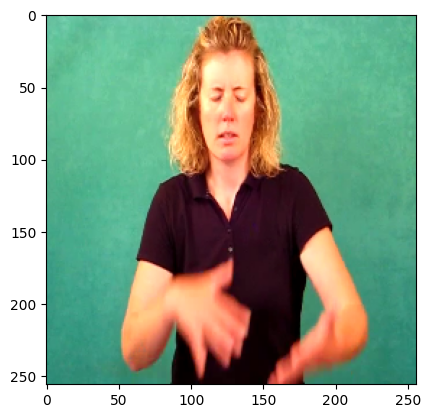

In [36]:
frame = X_aug[1][3]
# frame = X_aug[4][8]
# frame = X[15][4]
plt.imshow(frame)


In [37]:
results = detect_landmarks(frame)
x_coord_R_hand, y_coord_R_hand, z_coord_R_hand = get_coord_for_R_hand(results)
x_coord_L_hand, y_coord_L_hand, z_coord_L_hand = get_coord_for_L_hand(results)
x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)


❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated


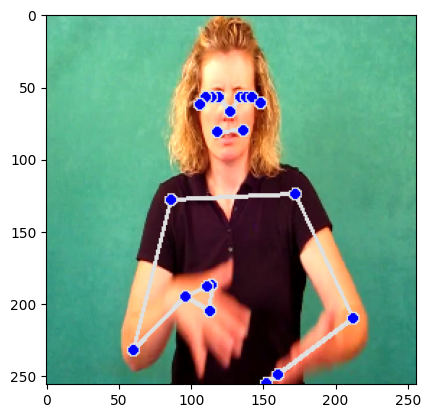

In [38]:
annotated_image = draw_(results, frame)
plt.imshow(annotated_image)


In [39]:
print(len(x_coord_R_hand))
print(len(y_coord_R_hand))
print(len(z_coord_R_hand))
print(len(x_coord_L_hand))
print(len(y_coord_L_hand))
print(len(z_coord_L_hand))
print(len(x_coord_pose))
print(len(y_coord_pose))
print(len(z_coord_pose))


21
21
21
21
21
21
14
14
14


In [40]:
X_frame = coordinates_per_frame(results)
len(X_frame)


❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected


168

### 2.3 Get coordinates for all frames

In [41]:
X_aug.shape


(484, 20, 256, 256, 3)

In [42]:
def mediapipe_video_to_coord(X):
    X_coord = []

    for video_count in range(len(X)):
        video = X[video_count]
        video_frames = []

        for frame_count in range(10):
            frame = video[frame_count]
            results = detect_landmarks(frame)
            X_frame = coordinates_per_frame(results)
            video_frames.append(X_frame)

        X_coord.append(video_frames)

    X_coord = tf.convert_to_tensor(X_coord)
    return X_coord


In [43]:
X_aug_coord = mediapipe_video_to_coord(X_aug)
X_aug_coord.shape


❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Right hand detected
✅ Left hand detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
❌ Pose not detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
✅ Right hand detected
✅ Left hand detected
✅ Pose detected
✅ R

TensorShape([484, 10, 168])

In [44]:
X_val_coord = mediapipe_video_to_coord(X_val)
X_val_coord.shape


❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Right hand detected
✅ Left hand detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Right hand detected
✅ Left hand detected
✅ Pose detected
✅ Right hand detected
✅ Left hand detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌ Left hand not detected
✅ Pose detected
❌ Right hand not detected
❌

TensorShape([19, 10, 168])

### 2.4 Get coordinates for videos?

In [101]:
word = "family"
video_list = list(selected_df[selected_df["word"] == word]["video_id"])
video_list


['69316',
 '20980',
 '20981',
 '20982',
 '20983',
 '20986',
 '20987',
 '65677',
 '20978',
 '20992',
 '20979']

In [102]:
def detect_landmarks_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=False) as holistic:
        results = holistic.process(frame_rgb)
    return results

for video in video_list:
    video_path = f"../data/videos/{video}.mp4"
    output_video_path = f"../data/videos_test/{video}_annotated.mp4"

    cap = cv2.VideoCapture(video_path)

    # Get video details
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(filename=output_video_path, fourcc=fourcc, fps=20, frameSize=(frame_width, frame_height))

    if not out.isOpened():
        print("Could not open output video file for writing.")

    while cap.isOpened():
        print("------")
        ret, frame = cap.read()
        if not ret:
            break

        # Process the frame for landmark detection
        results = detect_landmarks_frame(frame)

        # Draw landmarks on the frame
        annotated_image = draw_(results, frame)

        # Write the frame with annotations to the output video
        out.write(annotated_image)

        # cv2.imshow('Video', annotated_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()


------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated
------
❌ Right hand not annotated
❌ Left hand not annotated
✅ Pose annotated

In [83]:
cap.isOpened()


True

Could not open output video file for writing.


# 3. Prepare X_train, X_val, y_train, y_val

In [46]:
X_train = X_aug_coord
X_val = X_val_coord
y_train = y_aug
y_val = y_cat_val

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


(484, 10, 168)
(19, 10, 168)
(484, 6)
(19, 6)


# 4. Train and evaluate model (using simple RNN)

In [47]:
dim = 168


In [103]:
def model_initialize_simple(dim):
    model = Sequential()
    model.add(layers.Masking(input_shape=(10, dim), mask_value=0))
    model.add(layers.LSTM(units=256, activation="tanh", return_sequences=True))
    model.add(layers.LSTM(units=128, activation="tanh"))
    model.add(layers.Dense(6, activation="softmax"))
    return model

model = model_initialize_simple(dim)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 10, 168)           0         
                                                                 
 lstm (LSTM)                 (None, 10, 256)           435200    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 633,094
Trainable params: 633,094
Non-trainable params: 0
_________________________________________________________________


In [104]:
learning_rate = 1e-4

def model_compile(model):
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"]
    )
    return model

model = model_compile(model)


In [105]:
es = EarlyStopping(patience=50, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[es]
)


Epoch 1/300
31/31 [==============================] - 7s 67ms/step - loss: 1.7693 - accuracy: 0.1983 - val_loss: 1.7574 - val_accuracy: 0.2632
Epoch 2/300
31/31 [==============================] - 1s 19ms/step - loss: 1.6770 - accuracy: 0.3306 - val_loss: 1.7843 - val_accuracy: 0.3158
Epoch 3/300
31/31 [==============================] - 1s 20ms/step - loss: 1.6224 - accuracy: 0.3368 - val_loss: 1.8422 - val_accuracy: 0.1053
Epoch 4/300
31/31 [==============================] - 1s 22ms/step - loss: 1.5615 - accuracy: 0.3822 - val_loss: 1.8482 - val_accuracy: 0.1053
Epoch 5/300
31/31 [==============================] - 1s 19ms/step - loss: 1.5240 - accuracy: 0.3988 - val_loss: 1.8928 - val_accuracy: 0.1053
Epoch 6/300
31/31 [==============================] - 1s 20ms/step - loss: 1.4783 - accuracy: 0.4008 - val_loss: 1.9826 - val_accuracy: 0.1053
Epoch 7/300
31/31 [==============================] - 1s 19ms/step - loss: 1.4247 - accuracy: 0.4298 - val_loss: 2.0167 - val_accuracy: 0.2632
Epoch 

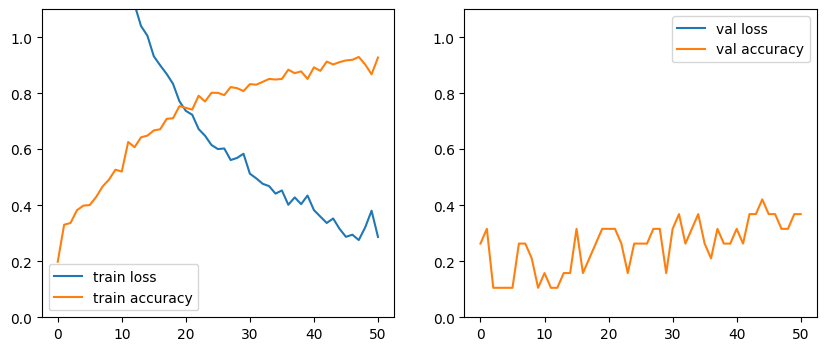

In [106]:
def plot_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

    ax1.plot(history.__dict__["history"]["loss"], label="train loss")
    ax1.plot(history.__dict__["history"]["accuracy"], label="train accuracy")
    ax1.legend()
    ax1.set_ylim(0,1.1)

    ax2.plot(history.__dict__["history"]["val_loss"], label="val loss")
    ax2.plot(history.__dict__["history"]["val_accuracy"], label="val accuracy")
    ax2.legend()
    ax2.set_ylim(0,1.1)

plot_accuracy(history)
